In [1]:
import os
import yaml
import pickle
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import scipy.io
import pickle
from statistics import mean
from plot import remove_repetitive_labels
from torch.utils.data import DataLoader, Dataset

from transformer_model import *
from process_data import Task_data
from outlier_detection import detect_outlier
from transformations import *
from quaternion_metric import *

%matplotlib notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Cuda available: ", torch.cuda.is_available())
# program seed and model seed
seed = 321
random.seed(seed)
# torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(seed)


def get_quaternion_difference_per_step(q1, q2):
    dq = []
    for i in range(q1.shape[0]):
        dq.append(norm_diff_quat(q1[i], q2[i]))
    return np.array(dq)

def get_position_difference_per_step(d1, d2):
    return np.linalg.norm(d1 - d2, axis = 1)

def swap_dict_level(data):
    temp = {}
    for obj, value in data.items():
        for demo, traj in value.items():
            if not demo in temp:
                temp[demo] = {}
            temp[demo][obj] = traj
    return temp

def create_tags(objs):
    one_hots = torch.eye(len(objs))
    tag_dict = {}
    for i, obj in enumerate(objs):
        tag_dict[obj] = one_hots[i]
    return tag_dict

def to_obj_index(onehot):
    for i in range(onehot.shape[0]):
        if onehot[i]==1:
            return i
    return 0

def find_task_by_index(demo_index, breaks):
    task_index = -1
    for br in breaks:
        if br > demo_index: break
        task_index += 1
    return task_index
    

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def create_chunks_of_indices(size, total, splits):
    offset = int(total/splits)
    all_indices = list(range(total))
    output = []
    for i in range(splits):
        holder = all_indices[offset*i:offset*i+size] + all_indices[:max(offset*i+size-total, 0)]
        output.append(sorted(holder))
    return output

# Settings
ENABLE_TRANSFORMATION = True
TEST_ENCODER_LAYERS = False
USE_VIA_POINT = False
MODEL_PATH = "./models_v3/masked_models" # read model from directory
TRAIN_LOG_DIR = './logs'  # saved trajectory directory (non-transformer models)
# saved trajectories from other models
SAVED_TRAJ_VER = "saved_traj_9-10-23" # saved trajectory subdirectory (non-transformer models)
MODEL_COPIES = 3 # model copies for training different model on different unique demos

colors = ['red', 'blue', 'yellow', 'orange', 'green', 'purple','pink']
task_files = ["2022-10-06", "2022-10-27", "2022-12-01"]
data_dir = '../Process_data/postprocessed'

task_dims = ['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']
# task_dims = ['x', 'y', 'z']
n_dims = len(task_dims)
n_train = 30
n_tasks = len(task_files)
# model copy number, also determine which subset of demos to use
kth=0

#=================
start_obj_index = [0,0,1]
#=================

# find all objects first
all_objs = []
for file in task_files:
    task_config_dir = os.path.join(data_dir, file)
    with open(os.path.join(task_config_dir, 'task_config.yaml')) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    objs = config["individuals"]
    all_objs = all_objs + objs
# instaniate all object type and enable/disable via-points
unique_objs = ['trajectory'] + sorted(list(set(all_objs)))
if USE_VIA_POINT: unique_objs = ['trajectory','via-point'] + sorted(list(set(all_objs)))
if TEST_ENCODER_LAYERS: n_encoder_layers_set = [0,1,2,3]
n_objs = len(unique_objs)
obj_tags = create_tags(unique_objs) # tags created based on unique objects and added later on to object sequences
task_tags = create_tags(task_files)

train_objs_pos, train_traj_pos = [], []
valid_objs_pos, valid_traj_pos = [], []
test_objs_pos, test_traj_pos = [], []

all_test_demos = []
all_global_gripper_traj_in_obj = {}
test_splits = []
saved_objects = {}
# Load all task data and create data test/training splits
for i, task_file in enumerate(task_files):
    task_config_dir = os.path.join(data_dir, task_file)
    with open(os.path.join(task_config_dir, 'task_config.yaml')) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    project_dir = config["project_path"] # Modify this to your need
    base_dir = os.path.join(project_dir, config["postprocessed_dir"])
    triangulation = 'dlc3d'
    template_dir = os.path.join(project_dir, config["postprocessed_dir"],f'transformations/{triangulation}')
    individuals = config["individuals"] # The objects that we will place a reference frame on
    saved_objects[task_file] = individuals
    with open(os.path.join(base_dir, 'processed', triangulation, 'gripper_trajs_in_obj_aligned_filtered.pickle',), 'rb') as f1:
        gripper_trajs_in_obj_all_actions = pickle.load(f1)
    with open(os.path.join(base_dir, 'processed', triangulation, 'HTs_obj_in_ndi.pickle',), 'rb') as f2:
        HTs_obj_in_ndi_all_actions = pickle.load(f2)
    with open(os.path.join(base_dir, 'processed', triangulation, 'gripper_traj_in_grouped_objs_aligned_filtered.pickle',), 'rb') as f3:
        gripper_trajs_in_grouped_objs_all_actions = pickle.load(f3)
    with open(os.path.join(base_dir, 'processed', triangulation, 'HTs_grouped_objs_in_ndi.pickle',), 'rb') as f4:
        HTs_grouped_objs_in_ndi_all_actions = pickle.load(f4)

    ind = 0  # index of action to be tested
    # gripper_trajs_in_ndi = gripper_trajs_truncated[ind]
    gripper_traj_in_obj = gripper_trajs_in_obj_all_actions[ind]
    gripper_traj_in_grouped_obj = gripper_trajs_in_grouped_objs_all_actions[ind]
    gripper_traj_in_generalized_obj = gripper_traj_in_obj | gripper_traj_in_grouped_obj

    HTs_obj_in_ndi = HTs_obj_in_ndi_all_actions[ind]
    HTs_grouped_obj_in_ndi = HTs_grouped_objs_in_ndi_all_actions[ind]
    if not 'global' in HTs_obj_in_ndi.keys():
        HTs_obj_in_ndi = swap_dict_level(HTs_obj_in_ndi)
        HTs_grouped_obj_in_ndi = swap_dict_level(HTs_grouped_obj_in_ndi)
    HTs_generalized_obj_in_ndi = HTs_obj_in_ndi | HTs_grouped_obj_in_ndi

    outliers = []
    std_thres = 3
    valid_size = 5

    for individual in individuals:
        n_std = std_thres
        outlier_individual = detect_outlier(gripper_traj_in_generalized_obj[individual], n=n_std)
        print(f'The outliers for individual {individual} are {outlier_individual}')
        outliers += outlier_individual
    outliers = list(set(outliers))
    bad_demos = outliers

    demos = sorted(list(HTs_generalized_obj_in_ndi['global'].keys()))
    demos = [demo for demo in demos if demo not in bad_demos]
    
    train_demos_pool = [demo for demo in random.sample(demos,30)]
    random.shuffle(train_demos_pool)
    test_valid_demos_pool_updated = [demo for demo in demos if demo not in train_demos_pool]
    
    # select unique training demo indices based on model copy number
    selected_indices = create_chunks_of_indices(n_train, len(train_demos_pool), MODEL_COPIES)[kth]
    train_demos = [val for i, val in enumerate(train_demos_pool) if i in selected_indices]
    print(f"{task_file}-{individuals}\nTraining Indices: {selected_indices}\nTraining Demos: {train_demos}")
    # validation and test demo split
    split_size = int(len(test_valid_demos_pool_updated)/2)
    valid_demos = test_valid_demos_pool_updated[:split_size]
    test_demos = test_valid_demos_pool_updated[split_size:]
    print(f'The number of training pool for task {task_file} is: {len(train_demos_pool)}')
    print(f'The number of outliers is: {len(outliers)} with remaining {len(demos)}')
    print(f'Training/Test Size: {len(train_demos)}/{len(test_demos)}')
    for demo in train_demos:
        traj = gripper_traj_in_obj['global'][demo][task_dims].to_numpy()
        traj_len = traj.shape[0]
        obj_buffer = obj_tags['trajectory'].repeat([traj_len, 1])
        task_buffer = task_tags[task_file].repeat([traj_len, 1])
        
        new_traj_data = np.concatenate([traj, obj_buffer, task_buffer], axis=1)
        obj_pos_all = [] 
        for obj_ind in individuals:
            mat = HTs_generalized_obj_in_ndi[obj_ind][demo]
            if n_dims==3:
                obj_pos = np.concatenate([mat[:3,3], obj_tags[obj_ind], task_tags[task_file]])
            else:
                obj_pos = np.concatenate([mat[:3,3], R.from_matrix(mat[:3,:3]).as_quat(), obj_tags[obj_ind], task_tags[task_file]])
            obj_pos_all.append(obj_pos)
            
        train_objs_pos.append(np.stack(obj_pos_all))
        train_traj_pos.append(new_traj_data)
    
    for demo in valid_demos:
        traj = gripper_traj_in_obj['global'][demo][task_dims].to_numpy()
        traj_len = traj.shape[0]
        obj_buffer = obj_tags['trajectory'].repeat([traj_len, 1])
        task_buffer = task_tags[task_file].repeat([traj_len, 1])
        new_traj_data = np.concatenate([traj, obj_buffer, task_buffer], axis=1)
        obj_pos_all = [] 
        for obj_ind in individuals:
            mat = HTs_generalized_obj_in_ndi[obj_ind][demo]
            if n_dims==3:
                obj_pos = np.concatenate([mat[:3,3], obj_tags[obj_ind], task_tags[task_file]])
            else:
                obj_pos = np.concatenate([mat[:3,3], R.from_matrix(mat[:3,:3]).as_quat(), obj_tags[obj_ind], task_tags[task_file]])
            obj_pos_all.append(obj_pos)
        
        valid_objs_pos.append(np.stack(obj_pos_all))
        valid_traj_pos.append(new_traj_data)
    
    test_splits.append(len(test_traj_pos))
    for demo in test_demos:
        traj = gripper_traj_in_obj['global'][demo][task_dims].to_numpy()
        # == track gripper traj and demo ==
        all_test_demos.append(demo)
        all_global_gripper_traj_in_obj.update(gripper_traj_in_obj['global'])
        # =================================
        traj_len = traj.shape[0]
        obj_buffer = obj_tags['trajectory'].repeat([traj_len, 1])
        task_buffer = task_tags[task_file].repeat([traj_len, 1])
        new_traj_data = np.concatenate([traj, obj_buffer, task_buffer], axis=1)
        obj_pos_all = [] 
        for ind, obj_ind in enumerate(individuals):
            mat = HTs_generalized_obj_in_ndi[obj_ind][demo]
            if n_dims==3:
                obj_pos = np.concatenate([mat[:3,3], obj_tags[obj_ind], task_tags[task_file]])
            else:
                obj_pos = np.concatenate([mat[:3,3], R.from_matrix(mat[:3,:3]).as_quat(), obj_tags[obj_ind], task_tags[task_file]])
            obj_pos_all.append(obj_pos)
        
        
        test_objs_pos.append(np.stack(obj_pos_all))
        test_traj_pos.append(new_traj_data)
    print("test_demos:", test_demos)


2023-10-07 17:56:49.733555: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-07 17:56:49.819715: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-07 17:56:49.821250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-07 17:56:51.082522: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Cuda available:  True
The outliers for individual teabag1 are ['134734', '134772']
The outliers for individual cup are ['134732', '134733', '134734', '134726', '134742', '134735']
2022-10-06-['teabag1', 'cup']
Training Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Training Demos: ['134722', '134723', '134769', '134786', '134790', '134741', '134763', '134762', '134764', '134783', '134776', '134773', '134775', '134791', '134784', '134739', '134736', '134740', '134737', '134730', '134760', '134747', '134743', '134774', '134767', '134785', '134788', '134724', '134771', '134777']
The number of training pool for task 2022-10-06 is: 30
The number of outliers is: 7 with remaining 44
Training/Test Size: 30/7
test_de

In [2]:
print(f"ENABLE_TRANSFORMATION: {ENABLE_TRANSFORMATION}",
      f"\nVIA_POINT_ENABLED: {USE_VIA_POINT}",
      f"\nTEST_ENCODER_LAYERS: {TEST_ENCODER_LAYERS}")
contiguous_traj = np.concatenate(train_traj_pos)

ENABLE_TRANSFORMATION: True 
VIA_POINT_ENABLED: False 
TEST_ENCODER_LAYERS: False


In [3]:
# Define the augmentations and transformations
def random_rotation_wrapper(obj_seq , traj_seq, axis='x'):
    """Combine all before rotation"""
    x = np.concatenate([obj_seq, traj_seq])
    x = random_rotation(x, axis)
    obj_seq = x[:obj_seq.shape[0],:]
    traj_seq = x[obj_seq.shape[0]:,:]
    return obj_seq, traj_seq

def random_rotation(x, axis='x'):
    """Rotates the coordinates along the selected axis"""
    new_x = x.copy()
    degree, idx = random.randrange(0, 360), random.randrange(0, x.shape[0])
    rot = R.from_euler(axis, degree, degrees=True)
    H = np.zeros([4,4])
    H[:3,:3] = rot.as_matrix()
    rand_pt = x[idx,:3].copy()
    new_x[:,:3]  = new_x[:,:3] - rand_pt
    new_x[:,:7] = lintrans(new_x[:,:7], H)
    new_x[:,:3] = new_x[:,:3] + rand_pt
    return new_x

def add_viapoint(obj_seq , traj_seq, lower=0.25, upper=0.75):
    """Create via-point using existing trajectory"""
    traj_len = traj_seq.shape[0]
    via_point = traj_seq[random.randint(round(traj_len*lower), round(traj_len*0.75)),:].copy()
    via_point[3:7] = [0, 0, 0, 1]
    obj_type_len = len(obj_tags["via-point"])
    via_point[7:7+obj_type_len] = obj_tags["via-point"]
    obj_seq = np.concatenate([obj_seq, via_point.reshape(1,-1)], 0)
    return obj_seq , traj_seq


class TrajectoryDataset(Dataset):
    def __init__(self, obj_data, traj_data, transform_dims, transform=[],
                 max_seq_len=128, return_index=False):
        self.traj_data = traj_data
        self.obj_data = obj_data
        self.transform = transform
        self.dims = transform_dims
        self.max_seq_len = max_seq_len
        self.return_index = return_index

    def __getitem__(self, idx):
        traj_data = self.traj_data[idx].copy()
        obj_data = self.obj_data[idx].copy()
        
        # Transformation process
        for tf_func in self.transform:
            obj_data, traj_data = tf_func(obj_data, traj_data)
        
        # Pad trajectory sequence
        traj_data = torch.tensor(traj_data)
        obj_data = torch.tensor(obj_data)
        if traj_data.shape[0] < self.max_seq_len:
            diff = self.max_seq_len - traj_data.shape[0]
            pad = torch.zeros([diff, traj_data.shape[1]])
            traj_data = torch.cat([traj_data, pad])
        traj_hidden = traj_data.clone()
        traj_hidden[:,:self.dims] = 0
        if self.return_index:
            return obj_data, traj_data, traj_hidden, idx
        return obj_data, traj_data, traj_hidden

    def __len__(self):
        return len(self.obj_data)

def normalize_wrapper(average, std):
    """normalize for multiprocessing"""
    return lambda x: normalize_3d(x, average, std)

def normalize_3d(entry, average, std):
    entry[:,:3] = (entry[:,:3] - average)/std
    return entry
    
def get_obj_tag(entry):
    tag_seq = entry[n_dims:n_dims+n_objs]
    return (tag_seq == 1).nonzero(as_tuple=True)[0]

# Find training mean and std
train_mean = np.mean(contiguous_traj[:,:3], axis=0)
train_std = np.std(contiguous_traj[:,:3])/3
# Normalization
norm_func = normalize_wrapper(train_mean, train_std)
train_objs_pos = list(map(norm_func, train_objs_pos))
train_traj_pos = list(map(norm_func, train_traj_pos))
valid_objs_pos = list(map(norm_func, valid_objs_pos))
valid_traj_pos = list(map(norm_func, valid_traj_pos))
test_objs_pos = list(map(norm_func, test_objs_pos))
test_traj_pos = list(map(norm_func, test_traj_pos))

# extra transformations for fewer unique demos
size_modifier = int(60/n_train)

traj_transformations = []
if ENABLE_TRANSFORMATION: traj_transformations.append(random_rotation_wrapper)
if USE_VIA_POINT: traj_transformations.append(add_viapoint)

# Create dataloaders and applies the augmentation for training set only
training_data = TrajectoryDataset(train_objs_pos*size_modifier, train_traj_pos*size_modifier,
                                  n_dims, transform=traj_transformations)
valid_data = TrajectoryDataset(valid_objs_pos, valid_traj_pos, n_dims)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=64, shuffle=False)

In [4]:
# # %matplotlib notebook
# # shows random set of augmented trajectory
# matplotlib.rcParams.update({'font.size': 10})
# fig = plt.figure(figsize = (8, 6))
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.set_facecolor('white')
# ax.locator_params(nbins=3, axis='z')
# colors = ['red', 'blue', 'yellow', 'orange', 'green', 'purple','pink']
# for i_data, sample_data in enumerate(training_data):
#     obj_seq, traj_seq, _ = sample_data
#     traj_seq = traj_seq[traj_seq[:,n_dims]==1]
#     obj1_pos = obj_seq[1,]
#     obj0_pos = obj_seq[0,]
#     line = ax.plot(traj_seq[:,2], traj_seq[:,1], -traj_seq[:,0], '--', color=colors[i_data%len(colors)], 
#                    label = f'demo {i_data}')
#     ax.plot(obj1_pos[2], obj1_pos[1], -obj1_pos[0], 'o',
#             color=colors[i_data%len(colors)], label=f'{i_data}')
#     ax.plot(obj0_pos[2], obj0_pos[1], -obj0_pos[0], 'x',
#             color=colors[i_data%len(colors)], label=f'{i_data}')
# ax.set_xlabel('x (mm)')
# ax.set_ylabel('y (mm)')
# ax.set_zlabel('z (mm)')
# ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f'get_{a}lim')() for a in 'xyz')])
# handles, labels = ax.get_legend_handles_labels()
# newHandles_temp, newLabels_temp = remove_repetitive_labels(handles, labels)
# newLabels, newHandles = [], []

# for handle, label in zip(newHandles_temp, newLabels_temp):
#     if label not in ['start', 'middle', 'end']:
#         newLabels.append(label)
#         newHandles.append(handle)
# # plt.legend(newHandles, newLabels, loc = 'upper left',  prop={'size': 10})
# plt.show()

In [5]:
def norm_diff_quat_torch(q1, q2):
    """
    torch version of the norm_diff_quat function for loss (not used).
    """
    last_dim = len(q1.shape) - 1
    q1 = q1 / torch.norm(q1, dim=last_dim).unsqueeze(-1)
    q2 = q2 / torch.norm(q2, dim=last_dim).unsqueeze(-1)
    q3 = torch.stack([torch.norm(q1 + q2, dim=last_dim), torch.norm(q1 - q2, dim=last_dim)])
    qlosses = torch.min(q3, dim=0)
    return torch.mean(qlosses)

def custom_loss_func(pred, truth):
    """
    Custom loss (not used).
    """
    losses = F.mse_loss(pred[:,:,:3], truth[:,:,:3]) + norm_diff_quat_torch(pred[:,:,3:], truth[:,:,3:])
    print(losses,  F.mse_loss(pred[:,:,:3], truth[:,:,:3]), norm_diff_quat_torch(pred[:,:,3:], truth[:,:,3:]))
    return losses

def train_epoch(model, optimizer, t_dataloader):
    train_losses = []
    model.train()
    for sample_batched in t_dataloader:
        
        # input modification
        optimizer.zero_grad()
        
        obj_seq, traj_seq, traj_target = sample_batched
        mask = traj_target.clone().sum(dim=2).le(1).to(device)
        obj_seq_input = obj_seq.to(device)
        traj_seq_gt = traj_seq.to(device)
        traj_target_input = traj_target.to(device)
        output_seq = model(obj_seq_input, traj_target_input, mask)
        loss = F.mse_loss(output_seq, traj_seq_gt[:,:,:n_dims])
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses


In [6]:
# Model and training settings
n_encoder_layers = 3
n_decoder_layers = 3

print_interval = 10
best_score = 9999
total_epochs = 20000
learning_rate = 1e-3

# Model save file naming
postpostfix = "_" + ("vp" if USE_VIA_POINT else "nvp") + f"_model{kth}" + f"_{total_epochs}epochs"
file_postfix = f"{n_dims}D_{n_train}demos_{n_decoder_layers}d{n_encoder_layers}e{postpostfix}.pt"
checkpoint_file = os.path.join(MODEL_PATH, f"model_{file_postfix}") 


loss_hist = []
epoch = 0
# Load model or create new based on model settings
if os.path.exists(checkpoint_file):
    saved_file = torch.load(checkpoint_file)
    loss_hist = saved_file['losses']
    epoch = len(loss_hist)*print_interval
    new_model = saved_file['model']
    adam = saved_file['optimizer']
    print("Loaded Saved Model:", checkpoint_file)
else:
    new_model = TFEncoderDecoder(task_dim=n_dims + n_objs + n_tasks, traj_dim=n_dims,
                                 embed_dim=32, nhead=8, max_len=128, num_encoder_layers=n_encoder_layers, 
                                 num_decoder_layers=n_decoder_layers, device=device)
    adam = optim.Adam(new_model.parameters(), lr=learning_rate)
    print("Create New Model...")
    
# Count number of parameters
print(f"Model Parameters: {get_n_params(new_model)}")

Loaded Saved Model: ./models_v3/masked_models/model_7D_30demos_3d3e_nvp_model0_20000epochs.pt
Model Parameters: 838663


In [7]:
# # Optuna parameter search
# import optuna

# def objective(trial):
#     # Integer parameter
#     num_layers = trial.suggest_int("num_layers", 1, 6)

#     # Integer parameter (log)
#     embed_size = trial.suggest_categorical("embed_size", [2**i for i in range(4,9)])

#     # Integer parameter (discretized)
#     num_heads = trial.suggest_categorical("num_heads", [2**i for i in range(0,5)])


#     # Floating point parameter (log)
#     learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

#     # Floating point parameter (discretized)
#     drop_path_rate = trial.suggest_float("dropout_rate", 0.0, 1.0, step=0.1)
    
#     search_model = TFModelLite(task_dim=n_dims + n_objs + n_tasks, traj_dim=n_dims, 
#                             embed_dim=embed_size, nhead=num_heads, layers=num_layers,
#                               dropout=drop_path_rate).to(device)
#     search_opt = optim.Adam(search_model.parameters(), lr=drop_path_rate)
#     for i in range(1000):
#         t_losses  = train_epoch(search_model, search_opt, train_dataloader)
  
#     search_model.eval()
#     v_losses = []
#     for sample_batched in valid_dataloader:
#         obj_seq, traj_seq, traj_target = sample_batched
#         obj_seq_input = obj_seq.to(device)
#         traj_seq_gt = traj_seq.to(device)
#         traj_target_input = traj_target.to(device)
#         output_seq = search_model(obj_seq_input, traj_target_input)
#         loss = F.mse_loss(output_seq, traj_seq_gt[:,:,:n_dims])
#         v_losses.append(loss.item())
#     t_loss_mean, v_loss_mean = mean(t_losses), mean(v_losses)
#     print(f"Epoch {epoch}, Train/Valid Loss: {round(t_loss_mean,4)}/{round(v_loss_mean,4)}")
#     del search_model
#     return v_loss_mean
    
# study = optuna.create_study()
# study.optimize(objective, n_trials=100)

# study_file = os.path.join(model_path, "saved_study.pkl")
# with open(study_file, "wb") as fout:
#     pickle.dump(study, fout)

# study_file = os.path.join(model_path, "saved_study.pkl")
# saved_study = pickle.load(open(study_file, "rb"))

In [8]:
# ============== Training process ==============
save_interval = 1000
start = time.time()
#Run Training Code
start = time.time()
while epoch < total_epochs:
    t_losses = train_epoch(new_model, adam, train_dataloader)
    if epoch%print_interval==0:
        new_model.eval()
        v_losses = []
        for sample_batched in valid_dataloader:
            obj_seq, traj_seq, traj_target = sample_batched
            mask = traj_target.clone().sum(dim=2).le(1).to(device)
            obj_seq_input = obj_seq.to(device)
            traj_seq_gt = traj_seq.to(device)
            traj_target_input = traj_target.to(device)
            output_seq = new_model(obj_seq_input, traj_target_input, mask)
            loss = F.mse_loss(output_seq, traj_seq_gt[:,:,:n_dims])
            v_losses.append(loss.item())
        v_loss_mean = mean(v_losses)
        t_loss_mean = mean(t_losses)
        print(f"Epoch {epoch}, Training Loss: {round(t_loss_mean,4)}", f"Runtime: {round(time.time()-start, 2)}s")
        loss_hist.append([t_loss_mean])
        
#         # fixed interval saves (for plotting performance vs epochs)
#         if epoch % save_interval==0:
#             postpostfix_temp = "_" + ("vp" if USE_VIA_POINT else "nvp") + f"_model{kth}" + f"_{epoch}epochs_timeTest"
#             file_postfix_temp = f"{n_dims}D_{n_train}demos_{n_decoder_layers}d{n_encoder_layers}e{postpostfix_temp}.pt"
#             checkpoint_file_temp = os.path.join(MODEL_PATH, f"model_{file_postfix_temp}")
#             checkpoint = {'epoch': epoch,
#                           'time_passed':time.time() - start,
#                           'losses':loss_hist,
#                           'model': new_model,
#                           'optimizer': adam}
#             torch.save(checkpoint, checkpoint_file_temp)
#         if best_score > v_loss_mean:
#             best_score = v_loss_mean
#             best_epoch = epoch
#             best_file = os.path.join(MODEL_PATH, 'best', f"best_{file_postfix}")
#             best_checkpoint = { 
#                 'epoch': epoch,
#                 'best_epoch': best_epoch,
#                 'losses':loss_hist,
#                 'model': new_model,
#                 'optimizer': adam}
#             torch.save(best_checkpoint, best_file)
    epoch += 1

In [9]:
# # End of training model save 
# checkpoint = {'epoch': epoch,
#               'time_passed':time.time() - start,
#               'losses':loss_hist,
#               'model': new_model,
#               'optimizer': adam}
# torch.save(checkpoint, checkpoint_file)

In [10]:
# Load trained model
new_model.eval()
test_data = TrajectoryDataset(test_objs_pos, test_traj_pos, n_dims, return_index=True)
plot_dataloader = DataLoader(test_data, batch_size=1)
n_demos_list = [30]
n_demos_list = [5, 10, 20, 30]

In [11]:
# CHANGE AS NEEDED
# tp_model_dims = n_dims
# # tp_model_dims = 3
# models = ["tp-pmp","tp-gmm"]
# if TEST_ENCODER_LAYERS:
#     tf_models = [f"model_{tp_model_dims}D_{n_train}demos_{n_decoder_layers}d{layers}e{postpostfix}" for layers in range(4)]
# else:
# #     tf_models = [f"model_{tp_model_dims}D_{n_train}demos_{n_decoder_layers}d3e{postpostfix}"]
#     tf_models = []
#     for demo_size in n_demos_list:
#         tf_models = tf_models + [f"model_{tp_model_dims}D_{demo_size}demos_3d3e_nvp_model{i}" for i in range(3)]
# models = models + tf_models
# models = tf_models
# tf_models = [f"model_{tp_model_dims}D_{n_train}demos_{3}d{3}e_vp_q"]

In [12]:
task_names = ["Pick&Place", "Pouring", "Shooting"]
metrics = ["distance", "norm_diff"]
task_old_names = ["extrapolation", "pouring", "shooting"]
plot_colors = ['green','orange','blue','purple']

<IPython.core.display.Javascript object>


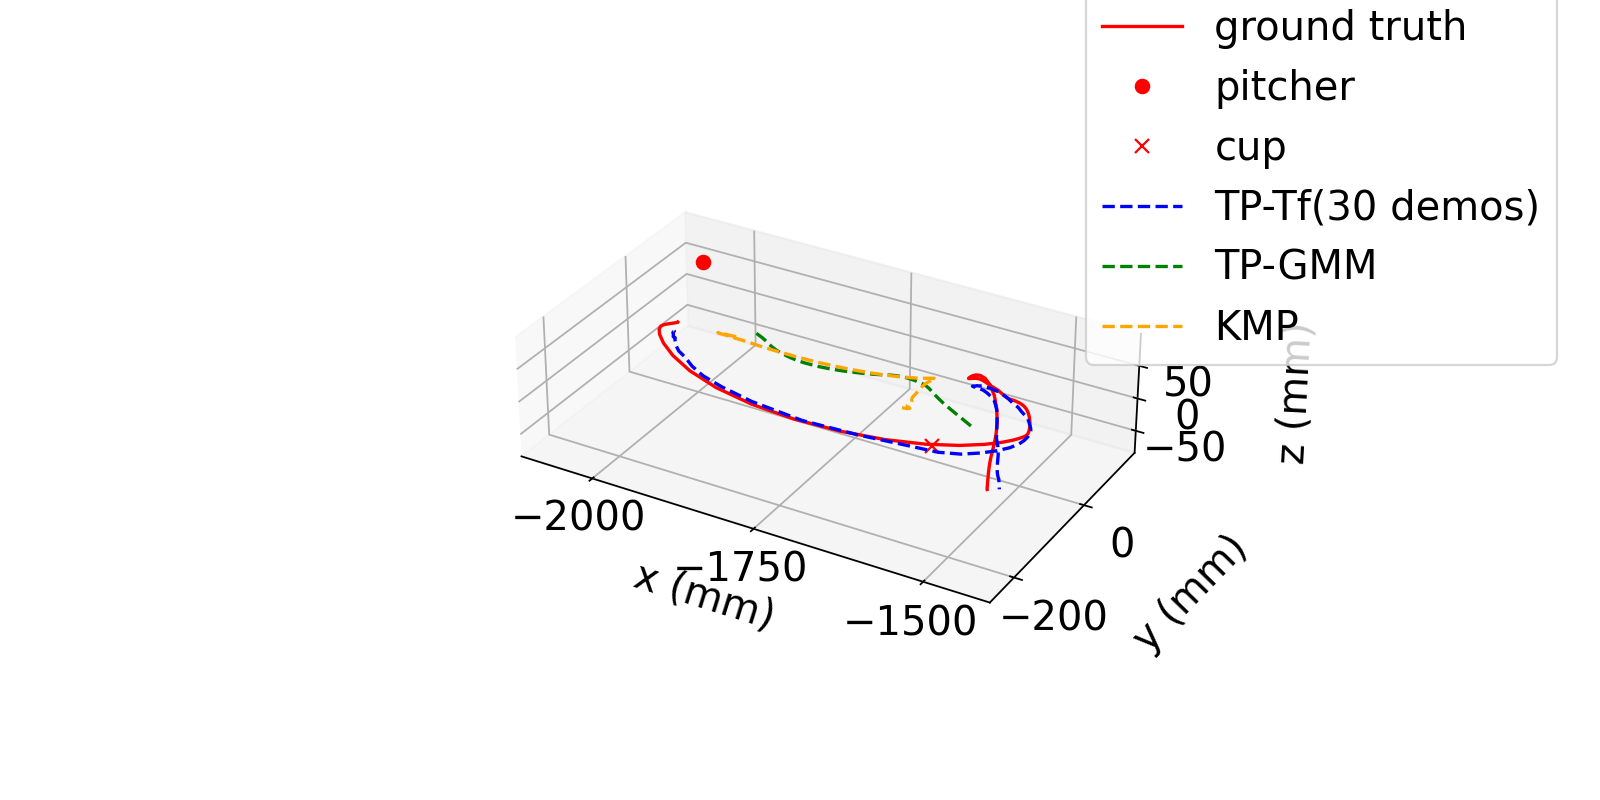

Model: model_7D_30demos_3d3e_nvp_model0_20000epochs.pt

./models_v3/masked_models/model_7D_30demos_3d3e_nvp_model0_20000epochs.pt-(7D-30 demos - size:838663):
 Position Difference - start: 28.82, end: 15.93, average: 30.77mm 
 Norm of differences - start: 0.055 end: 0.013 average: 0.04

tp-gmm Model(7D-30 demos):
 Position Difference - start: 137.57, end: 110.71 average: 139.8mm


In [13]:
# Select demo from data set based on index and plot predicted trajectory
input_index = 12
iterable_loader = iter(plot_dataloader)
demo_input = next(iterable_loader)
while input_index:
    input_index -= 1
    demo_input = next(iterable_loader)
obj_seq, traj_seq, traj_target, demo_idx = demo_input
obj_seq_input = obj_seq.to(device)
traj_target_input = traj_target.to(device)

task_idx = find_task_by_index(demo_idx, test_splits)
tfile = task_files[task_idx]
task_demo_idx = demo_idx - test_splits[task_idx]

%matplotlib notebook
matplotlib.rcParams.update({'font.size':18})
fig = plt.figure(figsize = (10, 5))
ax2 = fig.add_subplot(1, 1, 1, projection='3d')

line_type = ['--', '-']
obj0_pos = obj_seq[0,0,:3]*train_std+train_mean
obj1_pos = obj_seq[0,1,:3]*train_std+train_mean


mask = traj_seq[0,:,n_dims]==1
scaled_traj_seq = traj_seq[0,mask,:3]*train_std+train_mean
line = ax2.plot(scaled_traj_seq[:,2].tolist(), scaled_traj_seq[:,1].tolist(), (-scaled_traj_seq[:,0]).tolist(),
                 color='red', label = f'ground truth')
ax2.plot(obj0_pos[2], obj0_pos[1], -obj0_pos[0], 'o',
        color='red', label=f'{unique_objs[to_obj_index(obj_seq[0,0,][n_dims:n_dims+n_objs])]}')
ax2.plot(obj1_pos[2], obj1_pos[1], -obj1_pos[0], 'x',
        color='red', label=f'{unique_objs[to_obj_index(obj_seq[0,1,][n_dims:n_dims+n_objs])]}')
if USE_VIA_POINT and obj_seq.shape[1] > 2: 
    ax2.plot(viapt_pos[2], viapt_pos[1], -viapt_pos[0], 's',
        color='black', label=f'{unique_objs[to_obj_index(obj_seq[0,2,][n_dims:n_dims+n_objs])]}')

# Check only 3d3e transformer currently
for i, n_demos in enumerate([30]):
# for i, n_demos in enumerate(n_demos_list):
#     for e_layers in range(3):
#         load_file_postfix = f"model_7D_{n_demos}demos_3d{e_layers}e{postpostfix}.pt"
    load_file_postfix = f"model_{n_dims}D_{n_demos}demos_3d3e_nvp_model0_{total_epochs}epochs.pt"
    print("Model:", load_file_postfix)
    load_model_file = os.path.join(MODEL_PATH, load_file_postfix)
    saved_file = torch.load(load_model_file)
    saved_model = saved_file['model']
    saved_model.eval()

    predicted_traj_tf = saved_model(obj_seq_input, traj_target_input).cpu()
    predicted_traj = predicted_traj_tf.detach().numpy()

    d = get_position_difference_per_step(predicted_traj[0,mask,:3], traj_seq.numpy()[0,mask,:3])*train_std
    q = get_quaternion_difference_per_step(predicted_traj[0,mask,3:7], traj_seq.numpy()[0,mask,3:7])

    print(f"\n{load_model_file}-({n_dims}D-{n_demos} demos - size:{get_n_params(saved_model)}):\n Position Difference - start: {round(d[0],2)}, end: {round(d[-1],2)}, average: {round(np.mean(d),2)}mm",
          f"\n Norm of differences - start: {round(q[0],3)} end: {round(q[-1],3)} average: {round(np.mean(q),3)}")
    scaled_predicted_traj = predicted_traj[0,mask,:3]*train_std+train_mean
    line = ax2.plot(scaled_predicted_traj[:,2], scaled_predicted_traj[:,1], -scaled_predicted_traj[:,0], 
                    '--', color='blue', label = f'TP-Tf({n_demos} demos)')

    saved_traj_file = os.path.join(TRAIN_LOG_DIR, SAVED_TRAJ_VER, f"saved_trajs_7d_{n_demos}_{tfile}_model0.pkl")
    with open(saved_traj_file, "rb") as fout:
        model_outputs = pickle.load(fout)
        for m, md in enumerate(model_outputs.keys()):
            if len(model_outputs[md]) < 1 or md=='tp-pmp': continue
            task_model_traj = model_outputs[md][task_demo_idx]
            line2 = ax2.plot(task_model_traj[:,2], task_model_traj[:,1], -task_model_traj[:,0],
                             line_type[m%2], color="green", label = f'{md.upper()}')
            d = get_position_difference_per_step((task_model_traj[:,:3]-train_mean)/train_std, traj_seq.numpy()[0,mask,:3])*train_std
#                 q = get_quaternion_difference_per_step(task_model_traj[:,3:7], traj_seq.numpy()[0,mask,3:7])
            print(f"\n{md} Model({n_dims}D-{n_demos} demos):\n Position Difference - start: {round(d[0],2)}, end: {round(d[-1],2)} average: {round(np.mean(d),2)}mm")
#                 print(f"\n{md} Model({n_dims}D-{n_demos} demos):\n Position Difference - start: {round(d[0],2)}, end: {round(d[-1],2)} average: {round(np.mean(d),2)}mm",
#                      f"\n Norm of differences - start: {round(q[0],3)}, end: {round(q[-1],3)}, average: {round(np.mean(q),3)}")

    mat_traj_file = os.path.join(TRAIN_LOG_DIR, "tests", task_old_names[task_idx], "result",
                                               f"kmp_predictions_{n_demos}demos_{0}.mat")
    kmp_outputs = scipy.io.loadmat(mat_traj_file)['kmp_predictions']
    t_idx = task_demo_idx[0].item()
    task_model_traj = kmp_outputs[task_demo_idx]
    line2 = ax2.plot(task_model_traj[:,2], task_model_traj[:,1], -task_model_traj[:,0],
                     line_type[m%2], color="orange", label = f'KMP')
   
    
                
ax2.set_xlabel('x (mm)', labelpad=16)
ax2.set_ylabel('y (mm)', labelpad=16)
ax2.set_zlabel('z (mm)', labelpad=16)
ax2.locator_params(axis='both', nbins=3)
ax2.set_box_aspect([ub - lb for lb, ub in (getattr(ax2, f'get_{a}lim')() for a in 'xyz')])
# ax2.view_init(40, -80, 0)
plt.legend(bbox_to_anchor=(0.9, 1.2))
plt.show()

In [14]:
# matplotlib.rcParams.update({'font.size': 10})
# fig = plt.figure(figsize = (9, 2*n_dims))
# axs = fig.subplots(n_dims, 1)

# for i in range(n_dims):
#     axs[i].plot(-traj_seq[0,mask,i], color='red',  label = f' ground truth')
#     axs[i].plot(-predicted_traj[mask,i], color='blue', label=f'predict')
#     axs[i].set_xlabel('time')
#     axs[i].set_ylabel(task_dims[i])
#     axs[i].set_title(f'{task_dims[i]}-axis vs Time')
# plt.show()

In [15]:
# Get all model averages across task and size
# nesting order: 1.Demos size, 2.Task index, 3.Model, 4.Demo index, 
gt_traj_pts = {}
pd_traj_pts = {}
all_models_avgs = {}

for n_demos in n_demos_list:
    gt_traj_pts[n_demos] = {}
    pd_traj_pts[n_demos] = {}
    all_models_avgs[n_demos] = {}
    print("\n",'='*8, n_demos, "Unique Training Demos",'='*8)
    for i, file in enumerate(task_files):
        inference_times =[]
        gt_traj_pts[n_demos][i] = {}
        pd_traj_pts[n_demos][i] = {}
        all_models_avgs[n_demos][i] = {}
        print('-'*68)
        models_dist = {}
        models_norm_diff = {}
        # Transformer models
        for demo_input in plot_dataloader:
            obj_seq, traj_seq, traj_target, demo_idx = demo_input
            # Check belong to task
            if to_obj_index(task_tags[file])!=to_obj_index(obj_seq[0,0,-n_tasks:]): continue
            obj_seq_input = obj_seq.to(device)
            traj_target_input = traj_target.to(device)
            obj_start_pt = obj_seq[0,start_obj_index[i],]
            gt_traj_pts[n_demos][i][all_test_demos[demo_idx]] = obj_start_pt
            
                
            for k in range(MODEL_COPIES):
                model_name = f"model_{n_dims}D_{n_demos}demos_3d3e_nvp_model{k}_{total_epochs}epochs"
                load_model_file = os.path.join(MODEL_PATH, f"{model_name}.pt")
                saved_file = torch.load(load_model_file)
                saved_model = saved_file['model']
                saved_model.eval()
                start = time.time()
                predicted_traj_tf = saved_model(obj_seq_input, traj_target_input).cpu()
                inference_times.append(time.time()-start)
                predicted_traj = predicted_traj_tf.detach().numpy()[0]
                mask = traj_seq[0,:,n_dims]==1
                d = get_position_difference_per_step(predicted_traj[mask,:3], traj_seq.numpy()[0,mask,:3])*train_std
                q = get_quaternion_difference_per_step(predicted_traj[mask,3:7], traj_seq.numpy()[0,mask,3:7])
                # Initialize
                if (not model_name in models_dist): 
                    models_dist[model_name] = []
                    models_norm_diff[model_name] = []
                    pd_traj_pts[n_demos][i][model_name] = {}
                models_dist[model_name].append([d[0], d[-1], np.mean(d)])
                models_norm_diff[model_name].append([q[0], q[-1], np.mean(q)])
                task_idx = find_task_by_index(demo_idx, test_splits)
                tfile = task_files[task_idx]
                task_demo_idx = demo_idx - test_splits[task_idx]
                
                # Record ground truth
                pd_traj_pts[n_demos][i][model_name][all_test_demos[demo_idx]] = predicted_traj[mask,:3]
                
                # TP models
                saved_traj_file = os.path.join(TRAIN_LOG_DIR, SAVED_TRAJ_VER, f"saved_trajs_7d_{n_demos}_{file}_model{k}.pkl")
                if os.path.exists(saved_traj_file):
                    with open(saved_traj_file, "rb") as fout:
                        model_outputs = pickle.load(fout)
                        for m, mdl in enumerate(model_outputs.keys()):
                            total_test_size = len(model_outputs[mdl])
                            if total_test_size < 1: continue
                            t_idx = task_demo_idx[0].item()
                            task_model_traj = model_outputs[mdl][t_idx]
                            d = get_position_difference_per_step((task_model_traj[:,:3]-train_mean)/train_std, traj_seq.numpy()[0,mask,:3])*train_std
                            q = get_quaternion_difference_per_step(task_model_traj[:,3:7], traj_seq.numpy()[0,mask,3:7])
                            model_name = mdl + f"-{k}"
                            if (not model_name in models_dist): 
                                models_dist[model_name] = []
                                models_norm_diff[model_name] = []
                            models_dist[model_name].append([d[0], d[-1], np.mean(d)])
                            models_norm_diff[model_name].append([q[0], q[-1], np.mean(q)])
    #                             t_idx += offset_value
#                             pd_traj_pts[n_demos][i][mdl + f"-{k}"][all_test_demos[demo_idx]] = task_model_traj[:,:3]
                
                mat_traj_file = os.path.join(TRAIN_LOG_DIR, "tests", task_old_names[i], "result",
                                               f"kmp_predictions_{n_demos}demos_{k}.mat")
                kmp_outputs = scipy.io.loadmat(mat_traj_file)['kmp_predictions']
                t_idx = task_demo_idx[0].item()
                task_model_traj = kmp_outputs[t_idx]
                d = get_position_difference_per_step((task_model_traj[:,:3]-train_mean)/train_std, traj_seq.numpy()[0,mask,:3])*train_std
                q = get_quaternion_difference_per_step(task_model_traj[:,3:7], traj_seq.numpy()[0,mask,3:7])
                model_name = f"kmp-{k}"
                if (not model_name in models_dist):
                    models_dist[model_name] = []
                    models_norm_diff[model_name] = []
                models_dist[model_name].append([d[0], d[-1], np.mean(d)])
                models_norm_diff[model_name].append([q[0], q[-1], np.mean(q)])
                
        print(f"Task Name: {task_names[i]}, Avg Inference Time: {mean(inference_times)}")
        for model_k in models_dist.keys():
            tp_mean_ds = np.mean(np.array(models_dist[model_k]), axis = 0)
            tp_mean_qs = np.mean(np.array(models_norm_diff[model_k]), axis = 0)
#             print(f"{task_names[i]} {model_k.upper()}({tp_model_dims}D):\nPositions Difference - Start: {round(tp_mean_ds[0],2)}, End: {round(tp_mean_ds[1],2)}mm, Average: {round(tp_mean_ds[-1],2)}mm")
            print(f"{model_k}({n_dims}D):\nPos Diff - S: {round(tp_mean_ds[0],2)}, E: {round(tp_mean_ds[1],2)}, A: {round(tp_mean_ds[-1],2)}mm",
                  f"Quat - S: {round(tp_mean_qs[0],3)}, E: {round(tp_mean_qs[1],3)}, A: {round(tp_mean_qs[-1],3)}")
#             print(f"{model_k}({n_dims}D):\nPos Diff - S: {round(tp_mean_ds[0],2)}, E: {round(tp_mean_ds[1],2)}, A: {round(tp_mean_ds[-1],2)}mm",
#                   )
            
            # Save the average
            all_models_avgs[n_demos][i][model_k] = tp_mean_ds[-1]
        


 ======== 5 Unique Training Demos ========
--------------------------------------------------------------------
Task Name: Pick&Place, Avg Inference Time: 0.010490848904564268
model_7D_5demos_3d3e_nvp_model0_20000epochs(7D):
Pos Diff - S: 58.35, E: 84.32, A: 74.47mm Quat - S: 0.091, E: 0.12, A: 0.094
tp-pmp-0(7D):
Pos Diff - S: 15.17, E: 22.06, A: 83.48mm Quat - S: 0.062, E: 0.086, A: 0.075
tp-gmm-0(7D):
Pos Diff - S: 55.5, E: 147.65, A: 115.08mm Quat - S: 0.087, E: 0.138, A: 0.093
kmp-0(7D):
Pos Diff - S: 26.12, E: 41.39, A: 66.08mm Quat - S: 0.068, E: 0.09, A: 0.072
model_7D_5demos_3d3e_nvp_model1_20000epochs(7D):
Pos Diff - S: 23.59, E: 37.28, A: 45.86mm Quat - S: 0.063, E: 0.071, A: 0.061
tp-pmp-1(7D):
Pos Diff - S: 15.36, E: 19.93, A: 35.07mm Quat - S: 0.038, E: 0.06, A: 0.047
tp-gmm-1(7D):
Pos Diff - S: 33.76, E: 144.78, A: 86.31mm Quat - S: 0.039, E: 0.091, A: 0.062
kmp-1(7D):
Pos Diff - S: 14.25, E: 53.4, A: 47.05mm Quat - S: 0.036, E: 0.063, A: 0.047
model_7D_5demos_3d3e_nvp_

Task Name: Pick&Place, Avg Inference Time: 0.010404348373413086
model_7D_20demos_3d3e_nvp_model0_20000epochs(7D):
Pos Diff - S: 25.06, E: 45.31, A: 48.69mm Quat - S: 0.049, E: 0.058, A: 0.055
tp-pmp-0(7D):
Pos Diff - S: 15.38, E: 27.14, A: 50.33mm Quat - S: 0.059, E: 0.07, A: 0.067
tp-gmm-0(7D):
Pos Diff - S: 28.39, E: 94.69, A: 66.33mm Quat - S: 0.074, E: 0.101, A: 0.083
kmp-0(7D):
Pos Diff - S: 16.54, E: 40.41, A: 40.01mm Quat - S: 0.062, E: 0.073, A: 0.065
model_7D_20demos_3d3e_nvp_model1_20000epochs(7D):
Pos Diff - S: 16.27, E: 43.26, A: 39.52mm Quat - S: 0.048, E: 0.046, A: 0.05
tp-pmp-1(7D):
Pos Diff - S: 17.59, E: 27.63, A: 38.07mm Quat - S: 0.053, E: 0.071, A: 0.062
tp-gmm-1(7D):
Pos Diff - S: 28.93, E: 120.09, A: 77.92mm Quat - S: 0.064, E: 0.134, A: 0.076
kmp-1(7D):
Pos Diff - S: 19.49, E: 42.17, A: 39.43mm Quat - S: 0.054, E: 0.075, A: 0.06
model_7D_20demos_3d3e_nvp_model2_20000epochs(7D):
Pos Diff - S: 18.78, E: 50.62, A: 47.33mm Quat - S: 0.049, E: 0.071, A: 0.064
tp-pmp-2

In [16]:
# #Check model performance vs epochs
# pd_epochs_avgs = {}
# epoch_cps = [i for i in range(total_epochs+1) if i%500==0]
# for i, file in enumerate(task_files):
#     pd_epochs_avgs[i] = {}
#     models_dist = {}
#     models_norm_diff = {}
#     # Transformer models
#     for demo_input in plot_dataloader:
#         obj_seq, traj_seq, traj_target, demo_idx = demo_input
#         # Check belong to task
#         if to_obj_index(task_tags[file])!=to_obj_index(obj_seq[0,0,-n_tasks:]): continue
#         obj_seq_input = obj_seq.to(device)
#         traj_target_input = traj_target.to(device)

#         for epochs in epoch_cps:
#             model_name = f"model_{n_dims}D_30demos_3d3e_nvp_model0_{epochs}epochs_timeTest"
#             load_model_file = os.path.join(MODEL_PATH, f"{model_name}.pt")
#             saved_file = torch.load(load_model_file)
#             saved_model = saved_file['model']
#             saved_model.eval()

#             predicted_traj_tf = saved_model(obj_seq_input, traj_target_input).cpu()
#             predicted_traj = predicted_traj_tf.detach().numpy()[0]
#             mask = traj_seq[0,:,n_dims]==1
#             d = get_position_difference_per_step(predicted_traj[mask,:3], traj_seq.numpy()[0,mask,:3])*train_std
#             q = get_quaternion_difference_per_step(predicted_traj[mask,3:7], traj_seq.numpy()[0,mask,3:7])
#             # Initialize
#             if (not model_name in models_dist): 
#                 models_dist[model_name] = []
#                 models_norm_diff[model_name] = []
#             models_dist[model_name].append([d[0], d[-1], np.mean(d)])
#             models_norm_diff[model_name].append([q[0], q[-1], np.mean(q)])

#     for model_k in models_dist.keys():
#         tp_mean_ds = np.mean(np.array(models_dist[model_k]), axis = 0)
#         tp_mean_qs = np.mean(np.array(models_norm_diff[model_k]), axis = 0)
# #             print(f"{task_names[i]} {model_k.upper()}({tp_model_dims}D):\nPositions Difference - Start: {round(tp_mean_ds[0],2)}, End: {round(tp_mean_ds[1],2)}mm, Average: {round(tp_mean_ds[-1],2)}mm")
# #         print(f"{model_k}({n_dims}D):\nPos Diff - S: {round(tp_mean_ds[0],2)}, E: {round(tp_mean_ds[1],2)}, A: {round(tp_mean_ds[-1],2)}mm",
# #               f"Quat - S: {round(tp_mean_qs[0],3)}, E: {round(tp_mean_qs[1],3)}, A: {round(tp_mean_qs[-1],3)}")
#         pd_epochs_avgs[i][model_k] = tp_mean_ds[-1]
        
# # Plot performance vs epochs
# matplotlib.rcParams.update({'font.size': 14})
# fig = plt.figure(figsize = (6, 5))
# fig.tight_layout(pad=2.0)
# axs = fig.subplots(1, 1)

# for i, file in enumerate(task_files):
#     avgs_per_epoch = []
#     time_passed = []
#     for epochs in epoch_cps:
#         model_name = f"model_{n_dims}D_30demos_3d3e_nvp_model0_{epochs}epochs_timeTest"
#         load_model_file = os.path.join(MODEL_PATH, f"{model_name}.pt")
#         saved_file = torch.load(load_model_file)
#         saved_time_passed = saved_file['time_passed']
#         avgs_per_epoch.append(pd_epochs_avgs[i][model_name])
#         time_passed.append(saved_time_passed)

#     axs.plot(epoch_cps,  avgs_per_epoch, '--', label=f"{task_names[i]}")
# axs.set_xlabel(f"Epochs")
# axs.set_ylabel(f"Prediction Error (mm)")
# axs.set_xlim(0, 20000)
# axs.set_ylim(0, 140)

# plt.legend()
# plt.show()

In [17]:
# # Compare Encoder layers
# model_tags = [0,1,2,3,4,'no_aug']
# model_tags = [0,1,2,3,4]

# for i, file in enumerate(task_files):
#     print('-'*70)
#     models_dist = {t:[] for t in model_tags}
#     models_norm_diff = {t:[] for t in model_tags}
#     # Transformer models
#     for demo_input in plot_dataloader:
#         obj_seq, traj_seq, traj_target, demo_idx = demo_input
#         # Check belong to task
#         if to_obj_index(task_tags[file])!=to_obj_index(obj_seq[0,0,-n_tasks:]): continue
#         obj_seq_input = obj_seq.to(device)
#         traj_target_input = traj_target.to(device)

#         for layers in range(5):
#             for j in range(MODEL_COPIES):
#                 model_name = f"model_{n_dims}D_30demos_3d{layers}e_nvp_model{j}_{total_epochs}epochs"
#                 model_name_version = model_name
#                 load_model_file = os.path.join(MODEL_PATH, f"{model_name_version}.pt")
#                 saved_file = torch.load(load_model_file)
#                 saved_model = saved_file['model']
#                 saved_model.eval()

#                 predicted_traj_tf = saved_model(obj_seq_input, traj_target_input).cpu()
#                 predicted_traj = predicted_traj_tf.detach().numpy()[0]
#                 mask = traj_seq[0,:,n_dims]==1
#                 d = get_position_difference_per_step(predicted_traj[mask,:3], traj_seq.numpy()[0,mask,:3])*train_std
#                 q = get_quaternion_difference_per_step(predicted_traj[mask,3:7], traj_seq.numpy()[0,mask,3:7])
#                 # Initialize
#                 models_dist[layers].append([d[0], d[-1], np.mean(d)])
#                 models_norm_diff[layers].append([q[0], q[-1], np.mean(q)])
                
# #         for j in range(3):
# #             model_name = f"model_{n_dims}D_30demos_3d3e_nvp_model{j}_20000epochs_noAug"
# #             model_name_version = model_name
# #             load_model_file = os.path.join(MODEL_PATH, f"{model_name_version}.pt")
# #             saved_file = torch.load(load_model_file)
# #             saved_model = saved_file['model']
# #             saved_model.eval()

# #             predicted_traj_tf = saved_model(obj_seq_input, traj_target_input).cpu()
# #             predicted_traj = predicted_traj_tf.detach().numpy()[0]
# #             mask = traj_seq[0,:,n_dims]==1
# #             d = get_position_difference_per_step(predicted_traj[mask,:3], traj_seq.numpy()[0,mask,:3])*train_std
# #             q = get_quaternion_difference_per_step(predicted_traj[mask,3:7], traj_seq.numpy()[0,mask,3:7])
# #             # Initialize
# #             models_dist['no_aug'].append([d[0], d[-1], np.mean(d)])
# #             models_norm_diff['no_aug'].append([q[0], q[-1], np.mean(q)])

#     print(f"Task Name: {task_names[i]}")
#     for model_k in models_dist.keys():
#         tp_mean_ds = np.mean(np.array(models_dist[model_k]), axis = 0)
#         tp_mean_qs = np.mean(np.array(models_norm_diff[model_k]), axis = 0)
# #             print(f"{task_names[i]} {model_k.upper()}({tp_model_dims}D):\nPositions Difference - Start: {round(tp_mean_ds[0],2)}, End: {round(tp_mean_ds[1],2)}mm, Average: {round(tp_mean_ds[-1],2)}mm")
#         print(f"{model_k}({n_dims}D):\nPos Diff - S: {round(tp_mean_ds[0],2)}, E: {round(tp_mean_ds[1],2)}, A: {round(tp_mean_ds[-1],2)}mm",
#               f"Quat - S: {round(tp_mean_qs[0],3)}, E: {round(tp_mean_qs[1],3)}, A: {round(tp_mean_qs[-1],3)}")
# #             print(f"{model_k}({n_dims}D):".ljust(35), f"Pos Diff - A: {round(tp_mean_ds[-1],2)}mm",
# #                   f"Quat - A: {round(tp_mean_qs[-1],3)}")


# # result_path = "./result"
# # avg_file = os.path.join(result_path, f"avg_file{kth}.pkl")
# # with open(avg_file, "wb") as fout:
# #     pickle.dump(avg_dist_to_size, fout)

In [18]:
other_models = ['tp-gmm', 'kmp',]

<IPython.core.display.Javascript object>


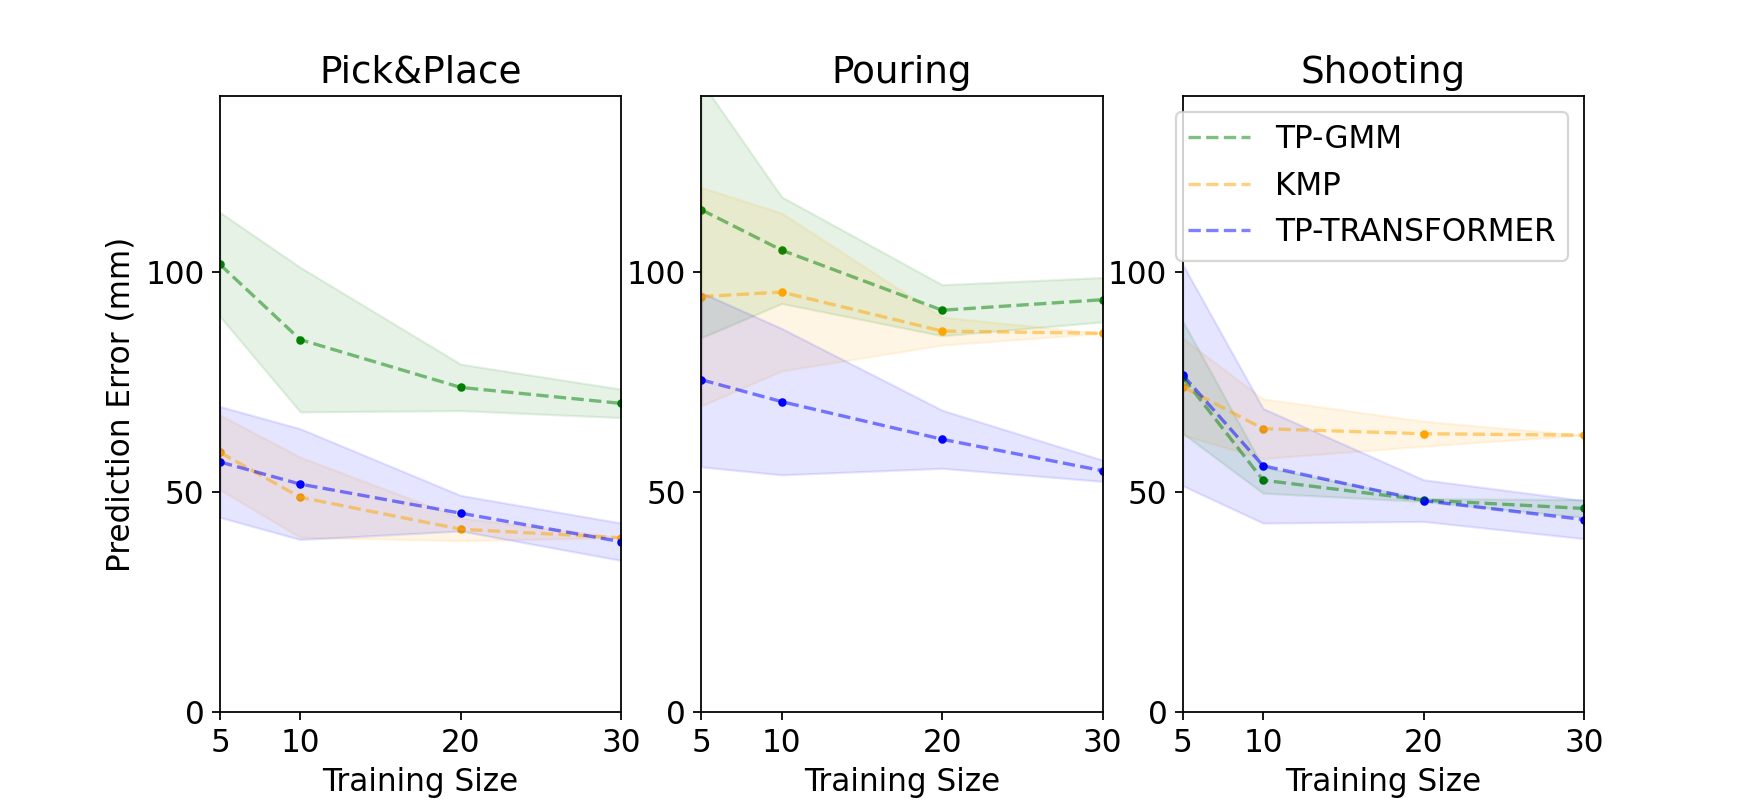

2022-10-06 [101.70530048  84.62778235  73.77124651  70.13527159]
2022-10-06 [58.99892065 48.79808667 41.54365326 39.60327779]
2022-10-06 [56.82643218 51.79210841 45.18066341 38.69836787]
2022-10-27 [114.14864889 104.95924493  91.30849343  93.70377206]
2022-10-27 [94.4064043  95.44092784 86.56934109 86.06053307]
2022-10-27 [75.50478759 70.53297708 61.98604997 54.82918758]
2022-12-01 [76.07730089 52.68748675 48.16778142 46.26110317]
2022-12-01 [73.92162509 64.3908895  63.23812737 62.91998712]
2022-12-01 [76.56705625 55.95721411 48.04558528 43.73135105]


In [19]:
# Model average standard deviation
matplotlib.rcParams.update({'font.size': 14})
fig = plt.figure(figsize = (11, 5))
fig.tight_layout(pad=2.0)
axs = fig.subplots(1, 3)
lims = (-600, 600)

plot_demo_size = 30
plot_dims = ["x", "y", "z"]

for i, file in enumerate(task_files):
    model_avg_mean = {m:[] for m in other_models + ['tp-transformer']}
    model_avg_std = {m:[] for m in other_models + ['tp-transformer']}
    for n_demos in n_demos_list:
        temp_avgs = {m:[] for m in other_models + ['tp-transformer']}
        for k in range(MODEL_COPIES):
            
            model_k = f"model_{n_dims}D_{n_demos}demos_3d3e_nvp_model{k}_{total_epochs}epochs"
            temp_avgs['tp-transformer'].append(all_models_avgs[n_demos][i][model_k])
            
            for mdl in other_models:
                other_model_k = f"{mdl}-{k}"
                temp_avgs[mdl].append(all_models_avgs[n_demos][i][other_model_k])
        
        for mdl in temp_avgs.keys():
#             axs[i].scatter(x = [n_demos for _ in range(MODEL_COPIES)], y = temp_avgs[mdl], s=4, c='red')
            model_avg_mean[mdl].append(np.mean(temp_avgs[mdl]))
            model_avg_std[mdl].append(np.std(temp_avgs[mdl]))
    for m, mdl in enumerate(model_avg_mean.keys()):
        model_avg_mean[mdl] = np.array(model_avg_mean[mdl])
        model_avg_std[mdl] = np.array(model_avg_std[mdl])
        print(file, model_avg_mean[mdl])
        axs[i].plot(n_demos_list,  model_avg_mean[mdl], '--', c=plot_colors[m], alpha=.5, label=mdl.upper())
        axs[i].scatter(x = n_demos_list, y = model_avg_mean[mdl], s=8, c=plot_colors[m])
        axs[i].fill_between(n_demos_list, (model_avg_mean[mdl]-model_avg_std[mdl]),
                            (model_avg_mean[mdl]+model_avg_std[mdl]), color=plot_colors[m], alpha=.1)
    axs[i].set_xlabel(f"Training Size")
    if i==0: axs[i].set_ylabel(f"Prediction Error (mm)")
#     if i==0: axs[i].set_ylabel(f"Norm of the Difference")
    axs[i].set_xlim(5, 30)
    axs[i].set_ylim(0, 140)
    axs[i].set_xticks([5,10,20,30])
#     axs[i].set_ylim(0, 0.6)
    axs[i].set_title(f"{task_names[i]}")
        
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


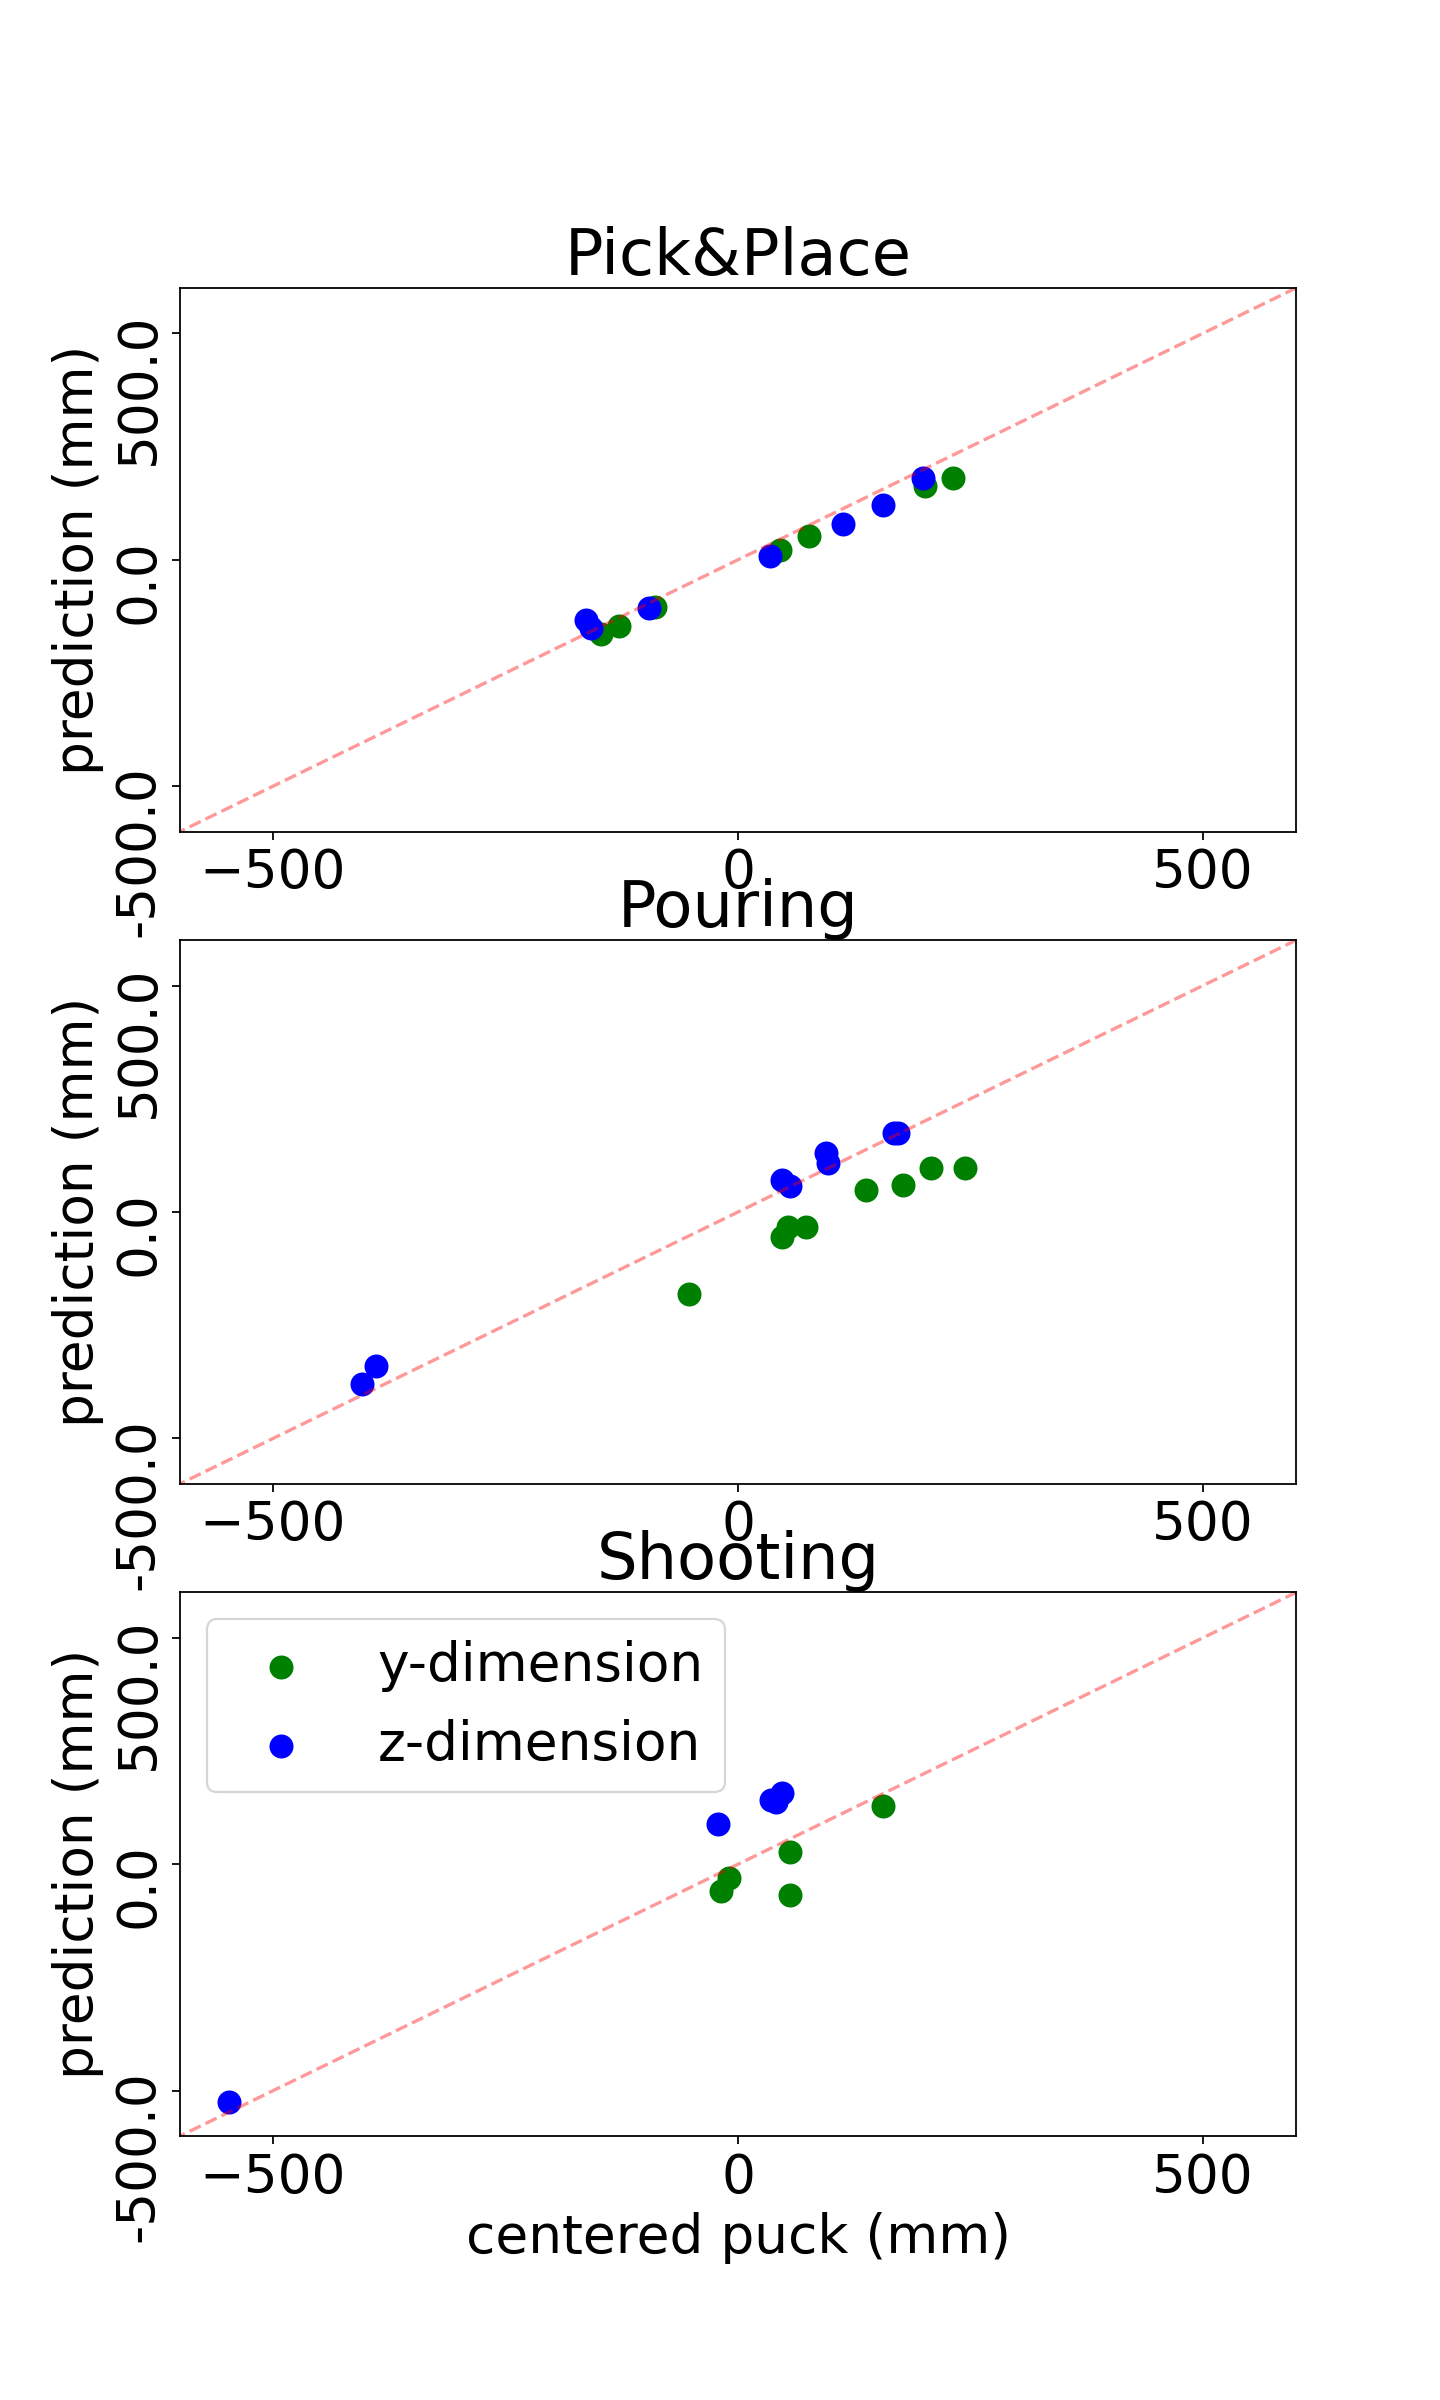

/tmp/ipykernel_6509/3489386764.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(axs[i].get_yticks(), rotation = 90)


In [20]:
# Correlation Graph
matplotlib.rcParams.update({'font.size': 24})
fig = plt.figure(figsize = (9, 15))
fig.tight_layout(pad=24.0)
axs = fig.subplots(3, 1)
lims = (-600, 600)

plot_colors = ['black','green','blue']
plot_demo_size = 30
plot_dims = ["x", "y", "z"]

for i, file in enumerate(task_files):
    gt_start_pts = []
    tf_start_pts = []
    for j in gt_traj_pts[plot_demo_size][i].keys():
        test_model = f"model_{n_dims}D_{n_demos}demos_3d3e_nvp_model0_{total_epochs}epochs"
        gt_start = gt_traj_pts[plot_demo_size][i][j].numpy()
        
        tf_start = pd_traj_pts[plot_demo_size][i][test_model][j][0,:]
        gt_start_pts.append(gt_start)
        tf_start_pts.append(tf_start)
    tf_start_pts = np.array(tf_start_pts)*train_std+train_mean
    gt_start_pts = np.array(gt_start_pts)
    obj_type = unique_objs[to_obj_index(gt_start_pts[0,n_dims:n_dims+n_objs])]
    gt_start_pts = gt_start_pts[:, :3]*train_std+train_mean - tf_start_pts.mean(axis=0)
    tf_start_pts -= tf_start_pts.mean(axis=0)
    axs[i].plot([-3000, 3000], [-3000, 3000], ls="--", c="red", alpha=0.4)
    for d in range(1, 3):
        axs[i].scatter(x = gt_start_pts[:,d], y = tf_start_pts[:,d], s=96, c=plot_colors[d],
                       label = f"{plot_dims[d]}-dimension")
    if i==2: axs[i].set_xlabel(f"centered {obj_type} (mm)")
    axs[i].set_ylabel(f"prediction (mm)")
    axs[i].set_xlim(lims[0], lims[1])
    axs[i].set_ylim(lims[0], lims[1])
    axs[i].set_title(f"{task_names[i]}")
    axs[i].locator_params(axis='both', nbins=4)
    axs[i].set_yticklabels(axs[i].get_yticks(), rotation = 90)

plt.legend()
plt.show()